In [1]:
# imports
import uproot3 as u
import numpy as np
import pandas as pd
import torch
import typing as t
from torch import Tensor
from torch import nn
from torch.nn.functional import normalize
from torch.nn import functional as F
from torch.nn import MSELoss, Module, Parameter
from torch.nn.utils import spectral_norm
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning import LightningModule
import math
from matplotlib import pyplot as plt
from typing import Any, Optional, TypeVar
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
plt.style.use('/home/kitouni/.dark_paper.mplstyle')
from tqdm.notebook import tqdm

In [2]:
class SpectralNorm:
    # Invariant before and after each forward call:
    #   u = normalize(W @ v)
    # NB: At initialization, this invariant is not enforced

    _version: int = 1
    # At version 1:
    #   made  `W` not a buffer,
    #   added `v` as a buffer, and
    #   made eval mode use `W = u @ W_orig @ v` rather than the stored `W`.
    name: str
    dim: int
    n_power_iterations: int
    eps: float

    def __init__(self, name: str = 'weight', n_power_iterations: int = 1, dim: int = 0, eps: float = 1e-12) -> None:
        self.name = name
        self.dim = dim
        if n_power_iterations <= 0:
            raise ValueError('Expected n_power_iterations to be positive, but '
                             'got n_power_iterations={}'.format(n_power_iterations))
        self.n_power_iterations = n_power_iterations
        self.eps = eps

    def reshape_weight_to_matrix(self, weight: torch.Tensor) -> torch.Tensor:
        weight_mat = weight
        if self.dim != 0:
            # permute dim to front
            weight_mat = weight_mat.permute(self.dim,
                                            *[d for d in range(weight_mat.dim()) if d != self.dim])
        height = weight_mat.size(0)
        return weight_mat.reshape(height, -1)

    def compute_weight(self, module: Module, do_power_iteration: bool) -> torch.Tensor:
        weight = torch.abs(getattr(module, self.name + '_orig'))
        u = getattr(module, self.name + '_u')
        v = getattr(module, self.name + '_v')
        weight_mat = self.reshape_weight_to_matrix(weight)

        if do_power_iteration:
            with torch.no_grad():
                for _ in range(self.n_power_iterations):
                    # Spectral norm of weight equals to `u^T W v`, where `u` and `v`
                    # are the first left and right singular vectors.
                    # This power iteration produces approximations of `u` and `v`.
                    v = normalize(torch.mv(weight_mat.t(), u), dim=0, eps=self.eps, out=v)
                    u = normalize(torch.mv(weight_mat, v), dim=0, eps=self.eps, out=u)
                if self.n_power_iterations > 0:
                    # See above on why we need to clone
                    u = u.clone(memory_format=torch.contiguous_format)
                    v = v.clone(memory_format=torch.contiguous_format)

        sigma = torch.dot(u, torch.mv(weight_mat, v))
        weight = weight / sigma
        return weight

    def remove(self, module: Module) -> None:
        with torch.no_grad():
            weight = self.compute_weight(module, do_power_iteration=False)
        delattr(module, self.name)
        delattr(module, self.name + '_u')
        delattr(module, self.name + '_v')
        delattr(module, self.name + '_orig')
        module.register_parameter(self.name, torch.nn.Parameter(weight.detach()))

    def __call__(self, module: Module, inputs: Any) -> None:
        setattr(module, self.name, self.compute_weight(module, do_power_iteration=module.training))

    def _solve_v_and_rescale(self, weight_mat, u, target_sigma):
        # Tries to returns a vector `v` s.t. `u = normalize(W @ v)`
        # (the invariant at top of this class) and `u @ W @ v = sigma`.
        # This uses pinverse in case W^T W is not invertible.
        v = torch.chain_matmul(weight_mat.t().mm(weight_mat).pinverse(), weight_mat.t(), u.unsqueeze(1)).squeeze(1)
        return v.mul_(target_sigma / torch.dot(u, torch.mv(weight_mat, v)))

    @staticmethod
    def apply(module: Module, name: str, n_power_iterations: int, dim: int, eps: float) -> 'SpectralNorm':
        for k, hook in module._forward_pre_hooks.items():
            if isinstance(hook, SpectralNorm) and hook.name == name:
                raise RuntimeError("Cannot register two spectral_norm hooks on "
                                   "the same parameter {}".format(name))

        fn = SpectralNorm(name, n_power_iterations, dim, eps)
        weight = module._parameters[name]

        with torch.no_grad():
            weight_mat = fn.reshape_weight_to_matrix(weight)

            h, w = weight_mat.size()
            # randomly initialize `u` and `v`
            u = normalize(weight.new_empty(h).normal_(0, 1), dim=0, eps=fn.eps)
            v = normalize(weight.new_empty(w).normal_(0, 1), dim=0, eps=fn.eps)

        delattr(module, fn.name)
        module.register_parameter(fn.name + "_orig", weight)
        # We still need to assign weight back as fn.name because all sorts of
        # things may assume that it exists, e.g., when initializing weights.
        # However, we can't directly assign as it could be an nn.Parameter and
        # gets added as a parameter. Instead, we register weight.data as a plain
        # attribute.
        setattr(module, fn.name, weight.data)
        module.register_buffer(fn.name + "_u", u)
        module.register_buffer(fn.name + "_v", v)

        module.register_forward_pre_hook(fn)
        module._register_state_dict_hook(SpectralNormStateDictHook(fn))
        module._register_load_state_dict_pre_hook(SpectralNormLoadStateDictPreHook(fn))
        return fn
    
def spectral_norm2(module,
                  name: str = 'weight',
                  n_power_iterations: int = 1,
                  eps: float = 1e-12,
                  dim: Optional[int] = None):
    if dim is None:
        if isinstance(module, (torch.nn.ConvTranspose1d,
                               torch.nn.ConvTranspose2d,
                               torch.nn.ConvTranspose3d)):
            dim = 1
        else:
            dim = 0
    SpectralNorm.apply(module, name, n_power_iterations, dim, eps)
    return module

# This is a top level class because Py2 pickle doesn't like inner class nor an
# instancemethod.
class SpectralNormStateDictHook:
    # See docstring of SpectralNorm._version on the changes to spectral_norm.
    def __init__(self, fn) -> None:
        self.fn = fn

    def __call__(self, module, state_dict, prefix, local_metadata) -> None:
        if 'spectral_norm' not in local_metadata:
            local_metadata['spectral_norm'] = {}
        key = self.fn.name + '.version'
        if key in local_metadata['spectral_norm']:
            raise RuntimeError("Unexpected key in metadata['spectral_norm']: {}".format(key))
        local_metadata['spectral_norm'][key] = self.fn._version
class SpectralNormLoadStateDictPreHook:
    # See docstring of SpectralNorm._version on the changes to spectral_norm.
    def __init__(self, fn) -> None:
        self.fn = fn

    # For state_dict with version None, (assuming that it has gone through at
    # least one training forward), we have
    #
    #    u = normalize(W_orig @ v)
    #    W = W_orig / sigma, where sigma = u @ W_orig @ v
    #
    # To compute `v`, we solve `W_orig @ x = u`, and let
    #    v = x / (u @ W_orig @ x) * (W / W_orig).
    def __call__(self, state_dict, prefix, local_metadata, strict,
                 missing_keys, unexpected_keys, error_msgs) -> None:
        fn = self.fn
        version = local_metadata.get('spectral_norm', {}).get(fn.name + '.version', None)
        if version is None or version < 1:
            weight_key = prefix + fn.name
            if version is None and all(weight_key + s in state_dict for s in ('_orig', '_u', '_v')) and \
                    weight_key not in state_dict:
                # Detect if it is the updated state dict and just missing metadata.
                # This could happen if the users are crafting a state dict themselves,
                # so we just pretend that this is the newest.
                return
            has_missing_keys = False
            for suffix in ('_orig', '', '_u'):
                key = weight_key + suffix
                if key not in state_dict:
                    has_missing_keys = True
                    if strict:
                        missing_keys.append(key)
            if has_missing_keys:
                return
            with torch.no_grad():
                weight_orig = state_dict[weight_key + '_orig']
                weight = state_dict.pop(weight_key)
                sigma = (weight_orig / weight).mean()
                weight_mat = fn.reshape_weight_to_matrix(weight_orig)
                u = state_dict[weight_key + '_u']
                v = fn._solve_v_and_rescale(weight_mat, u, sigma)
                state_dict[weight_key + '_v'] = v

In [3]:
def get_module(inputs=1, nunits=16, nlayers=3, norm=True, activation=nn.ReLU(), layer=nn.Linear, batchnorm=False, final_activation=False):
    normfunc = spectral_norm if norm else lambda x: x
    layers = [normfunc(layer(inputs, nunits)), activation]
    if batchnorm:
        layers.append(nn.BatchNorm1d(nunits))
    for i in range(nlayers - 1):
        layers.append(normfunc(layer(nunits, nunits)))
        layers.append(activation)
    layers.append(normfunc(layer(nunits, 1)))
    if final_activation: layers.append(final_activation)
    return nn.Sequential(*layers)

class PLM(LightningModule):
    def __init__(self, nn, loss=MSELoss(), lipschitz_const = 1):
        super().__init__()
        self.nn = nn
        self.loss = loss
        self.lipschitz_const = lipschitz_const

    def forward(self, x):
        x = self.lipschitz_const*self.nn(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = self.loss(self(x), y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self, learning_rate=1e-3):
        optimizer = torch.optim.Adam(self.nn.parameters(), lr=learning_rate)
        return optimizer

In [4]:
class PositiveLinear(torch.nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    func: callable
    weight: torch.Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True, func: callable = lambda x: torch.abs(x)) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.func = func
        self.reset_parameters()

    def reset_parameters(self) -> None:
        torch.nn.init.uniform_(self.weight, a=0,b=.02) #, a=math.sqrt(5)
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.func(self.weight), self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [5]:
def train(model, name='NN', plot=False, printed=True, Loss=F.binary_cross_entropy):
        # unconstrained
    plt.close()
    torch.manual_seed(2)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=.97)
    #torch.optim.lr_scheduler.MultiplicativeLR(optimizer=optimizer, lr_lambda= lambda x: (5e-5/LR)**(1/EPOCHS))


    fig =  plt.figure(dpi=120,figsize=(5,4))
    ax = plt.axes(projection='3d')

    c = np.array(['C0', 'crimson'])
    ax.set_zlim(-.01,1.01)
    #ax.scatter(x_train[:,0],x_train[:,1], y_train.view(-1), s=5, c=c[y_train.long().view(-1)],alpha=.2)
    # ax.scatter(x_val[:,0],x_val[:,1], y_val.view(-1), s=20, c='C1',alpha=.3)
    #c = np.array(['royalblue', 'C3'])
    c = np.array(['C0', 'crimson'])
    line = ax.scatter(x_val[:,0],x_val[:,1],torch.zeros_like(y_val), c=c[y_val.long().view(-1)], alpha =1, s=20)
    if printed: 
        iterator = tqdm(range(EPOCHS))
        writer = tqdm.write
    else:
        iterator = range(EPOCHS)
        writer = print
    for i in iterator:
        model.train()
        for x,y in loader:
            output = model(x)
            loss = Loss(output, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        with torch.no_grad():
                y_pred = model(x_val)
                loss = Loss(y_pred, y_val)
                model_acc = accuracy_score(y_val.view(-1), y_pred.view(-1)>.5)
                model_auc = roc_auc_score(y_val.view(-1), y_pred.view(-1))
                writer(f'Epoch {i+1}/{EPOCHS} , loss{loss.item():.3f}, acc{model_acc:.3f}, auc{model_auc:.3f}', end='\r')
                if plot:
                    line._offsets3d = x_val[:,0].numpy(),x_val[:,1].numpy(),y_pred.numpy().flatten()
                    ax.set_title(f' {name}\nEpoch {i+1}/{EPOCHS} , loss{loss.item():.3f}, acc{model_acc:.3f}, auc{model_auc:.3f}')
                    fig.canvas.draw()
        #         plt.pause(.001)
        #         fig.canvas.flush_events()
        scheduler.step()
        
    fig.tight_layout()
    print(f'naive bayes accuracy: {acc:.2f}')
    print(f'{name} accuracy: {model_acc:.2f}')
    print(f'naive bayes auc: {auc:.5f}')
    print(f'{name} auc: {model_auc:.5f}')

# Data 

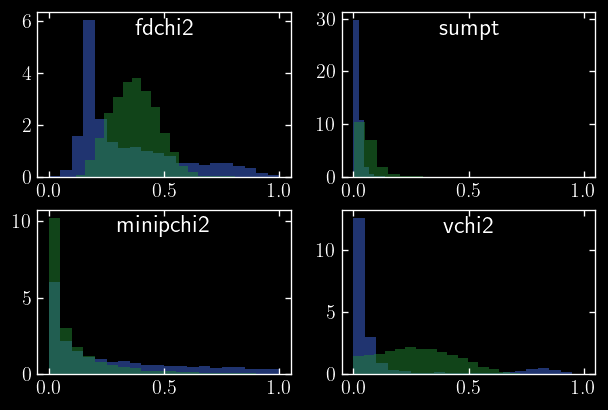

In [22]:
from hlt2trk.utils.meta_info import get_data_for_training
x_train, y_train, x_val, y_val = get_data_for_training(normalize=True)
X = np.concatenate([x_train, x_val], axis=0)
y = np.concatenate([y_train, y_val], axis=0)
features_names = ['fdchi2', 'sumpt', 'minipchi2', 'vchi2']
fig,axes = plt.subplots(2,2, dpi=120)
for i,ax in enumerate(axes.flatten()):
    ax.hist(X[:,i][y==0],bins=20, density=True, alpha=0.5)
    ax.hist(X[:,i][y==1],bins=20, density=True, alpha=0.5)
    ax.set_title(features_names[i],y=.8)

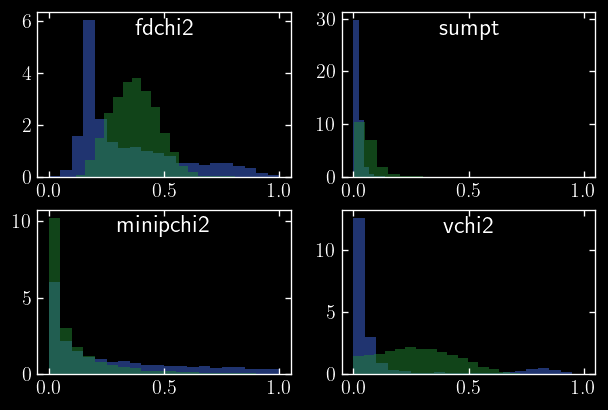

In [22]:
from hlt2trk.utils.meta_info import get_data_for_training
x_train, y_train, x_val, y_val = get_data_for_training(normalize=True)
X = np.concatenate([x_train, x_val], axis=0)
y = np.concatenate([y_train, y_val], axis=0)
features_names = ['fdchi2', 'sumpt', 'minipchi2', 'vchi2']
fig,axes = plt.subplots(2,2, dpi=120)
for i,ax in enumerate(axes.flatten()):
    ax.hist(X[:,i][y==0],bins=20, density=True, alpha=0.5)
    ax.hist(X[:,i][y==1],bins=20, density=True, alpha=0.5)
    ax.set_title(features_names[i],y=.8)

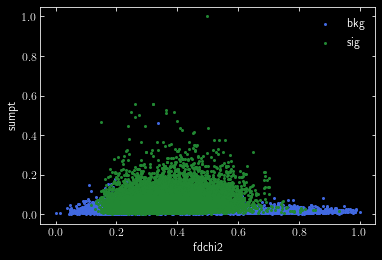

In [16]:
# plot
fig, a0 = plt.subplots(1,1)
a0.scatter(X[:,0][y==0], X[:,1][y==0], label='bkg', s=4)
a0.scatter(X[:,0][y==1], X[:,1][y==1], label='sig', s=4)
a0.set_xlabel(features_names[0])
a0.set_ylabel(features_names[1])
plt.legend()
fig.set_facecolor('k')
# fig.savefig('plots/data/sumpt_fdchi2-LHCb.png')

In [18]:
pca = PCA(4)
fit = pca.fit(X)
pca_var = ((pca.components_)**2*pca.explained_variance_ratio_.reshape(-1,1)).sum(axis=0)
mic = mutual_info_classif(X,y.reshape(-1))

In [19]:
print(*[f"PC-{i}" for i in range(1,5)], sep=', ')
print(*[f"{variance:.3f}"for variance in pca.explained_variance_ratio_], sep=', ')
print(*features_names, sep=', ')
print(*[f"{variance:.3f}"for variance in pca_var], sep=', ')
print(*[f"{f:.3f}" for f in mic],sep=', ')
df = pd.DataFrame(np.stack([pca_var, mic]))
df.index = ['Explained Variance', 'Mutual Information']
# print(df.to_latex(column_format='c'*(len(df.columns)+1), bold_rows=True, float_format="%.3f",multicolumn_format='c',
#                  caption = 'Fractional explained variance by feature (using PCA) and mutual information with\
#                  the binary label\
#                  (signal vs background.)'))

PC-1, PC-2, PC-3, PC-4
0.545, 0.382, 0.056, 0.017
fdchi2, sumpt, minipchi2, vchi2
0.178, 0.018, 0.437, 0.366
0.180, 0.189, 0.045, 0.284


# Fitting 

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

def get_metrics(x_train,x_val, method):
    method.fit(x_train, y_train.reshape(-1))
    preds = method.predict(x_val)
    probs = method.predict_proba(x_val)
    acc = max([balanced_accuracy_score(y_val.reshape(-1), probs[:,1]>cut) for cut in np.linspace(0,1,100)])
    auc = roc_auc_score(y_val.reshape(-1), probs[:,1])
    return acc,auc

## fitting qda, lda, gnb

In [30]:
# lda
lda_results = []
for i,(train, val) in enumerate(zip([x_train[:,-2:], x_train[:,:2], x_train],
                      [x_val[:,-2:], x_val[:,:2], x_val])):
    print(i)
    acc, auc = get_metrics(train,val,LinearDiscriminantAnalysis())
    print(f'{acc:.3f}')
    print(f'{auc:.3f}')
    lda_results.append([acc,auc])

0
0.794
0.803
1
0.765
0.855
2
0.804
0.870


In [32]:
# qda
qda_results = []
for i,(train, val) in enumerate(zip([x_train[:,-2:], x_train[:,:2], x_train],
                      [x_val[:,-2:], x_val[:,:2], x_val])):
    print(i)
    acc, auc = get_metrics(train,val,QuadraticDiscriminantAnalysis())
    print(f'{acc:.3f}')
    print(f'{auc:.3f}')
    qda_results.append([acc,auc])

0
0.844
0.885
1
0.837
0.918
2
0.878
0.932


In [33]:
gnb_results = []
for i,(train, val) in enumerate(zip([x_train[:,-2:], x_train[:,:2], x_train],
                      [x_val[:,-2:], x_val[:,:2], x_val])):
    print(i)
    acc, auc = get_metrics(train,val,GaussianNB())
    print(f'{acc:.3f}')
    print(f'{auc:.3f}')
    gnb_results.append([acc,auc])

0
0.840
0.880
1
0.836
0.917
2
0.894
0.944


## tables

In [39]:
df = pd.DataFrame(np.stack([lda_results, qda_results, gnb_results]).reshape(3,-1))
df.columns = [('1', 'acc'), ('1', 'auc'), ('2', 'acc'), 
              ('2', 'auc'), ('3', 'acc'), ('3', 'auc')]
df.columns = pd.MultiIndex.from_tuples(df.columns, names=['Experiment','metric'])
df.index = ['LDA', 'QDA', 'GNB']
print(df.to_latex(column_format='c'*7, bold_rows=True, float_format="%.3f",multicolumn_format='c',
                 caption = '1: uses minipchi2/vchi2, 2: uses fdchi2/sumpt, \
                 3: uses all four features.')
     )

\begin{table}
\centering
\caption{1: uses minipchi2/vchi2, 2: uses fdchi2/sumpt,                  3: uses all four features.}
\begin{tabular}{ccccccc}
\toprule
\textbf{Experiment} & \multicolumn{2}{c}{1} & \multicolumn{2}{c}{2} & \multicolumn{2}{c}{3} \\
\textbf{metric} &   acc &   auc &   acc &   auc &   acc &   auc \\
\midrule
\textbf{LDA} & 0.794 & 0.803 & 0.765 & 0.855 & 0.804 & 0.870 \\
\textbf{QDA} & 0.844 & 0.885 & 0.837 & 0.918 & 0.878 & 0.932 \\
\textbf{GNB} & 0.840 & 0.880 & 0.836 & 0.917 & 0.894 & 0.944 \\
\bottomrule
\end{tabular}
\end{table}



## NN

In [395]:
dataset = TensorDataset(x_train , y_train.view(-1,1))
loader = DataLoader(dataset, batch_size=128, shuffle=True)
EPOCHS = 100
LR = 2e-3

naive bayes accuracy: 0.89 acc0.912, auc0.961
NN accuracy: 0.91
naive bayes auc: 0.94954
NN auc: 0.96072


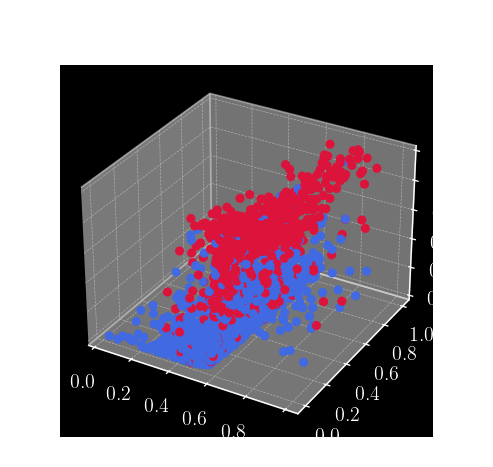

In [398]:
# unconstrained
torch.manual_seed(15)
model = PLM(get_module(inputs=4, nunits=10, nlayers=4, norm=False, activation=nn.LeakyReLU(), batchnorm=True),lipschitz_const=1)
train(model, plot=True,printed=False)

naive bayes accuracy: 0.89 acc0.900, auc0.957
Spectral5 accuracy: 0.90
naive bayes auc: 0.94954
Spectral5 auc: 0.95678


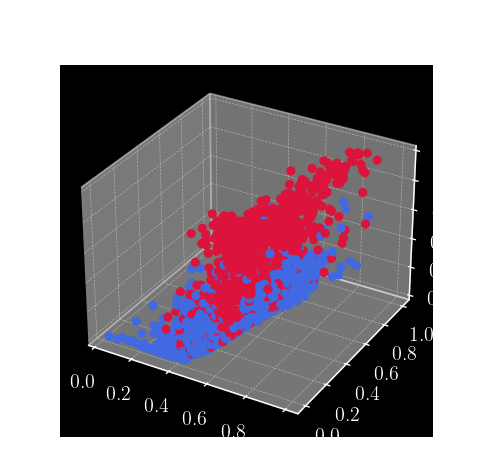

In [435]:
# lipnn5
torch.manual_seed(15)
model_spec = PLM(get_module(inputs=4, nunits=20, nlayers=6, norm=True, activation=nn.ReLU(), batchnorm=False),lipschitz_const=2)
train(model_spec, name='Spectral5', printed=False, plot=True, Loss=F.mse_loss)

naive bayes accuracy: 0.89 acc0.899, auc0.957
Spectral5monotonic accuracy: 0.90
naive bayes auc: 0.94954
Spectral5monotonic auc: 0.95677


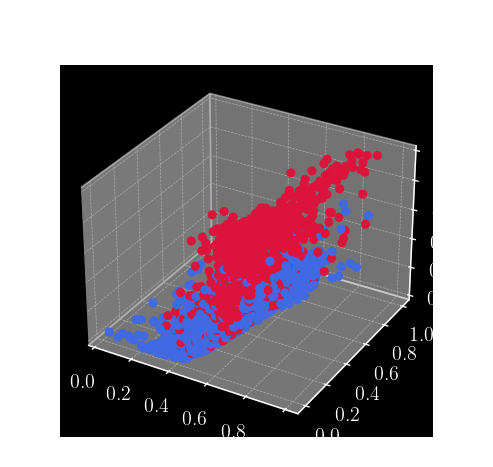

In [434]:
# Monotonic LipNN
plt.close()
torch.manual_seed(15)
module = nn.Sequential(get_module(inputs=4, nunits=10, nlayers=4, norm=spectral_norm2, activation=nn.ReLU(), 
                       layer=nn.Linear, batchnorm=False, final_activation= torch.nn.Tanh()))

model_specm = PLM(module,lipschitz_const=2)
train(model_specm, name='Spectral5monotonic', printed=False, plot=True, Loss=F.mse_loss)

naive bayes accuracy: 0.89 acc0.900, auc0.954
PositiveNN accuracy: 0.90
naive bayes auc: 0.94954
PositiveNN auc: 0.95440


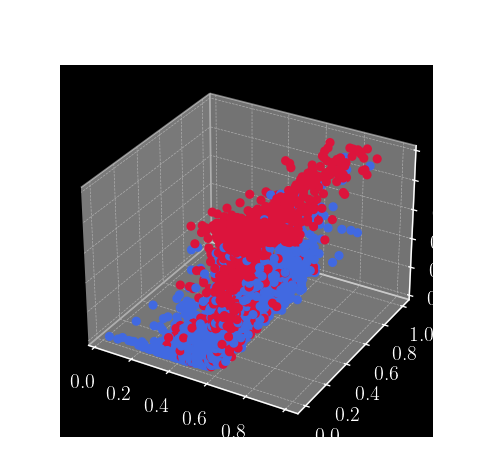

In [407]:
# positive weights
plt.close()
torch.manual_seed(15)

module = nn.Sequential(get_module(inputs=4, nunits=10, nlayers=4, norm=False, activation=nn.ReLU(), 
                       layer=PositiveLinear, batchnorm=False, final_activation=torch.nn.Tanh()))

model_pnn = PLM(module,lipschitz_const=1)
train(model_pnn, 'PositiveNN', printed=False, plot=True)

In [471]:
Xgrid = torch.from_numpy(np.random.uniform(size=100000*4).reshape(-1,4)).float()
ygrid = model(Xgrid)

In [473]:
with open('_local/feynman/example_data/unconstrained_4d_trig.txt', 'w') as f:
    for x,y in zip(tqdm(Xgrid),ygrid):
        lst  = [f'{i}' for i in x] +[f'{y.item()}\n']
        string = ' '.join(lst)
        f.write(string)

100%|██████████| 100000/100000 [00:02<00:00, 35004.47it/s]


Text(0.5, 1.0, 'spectral')

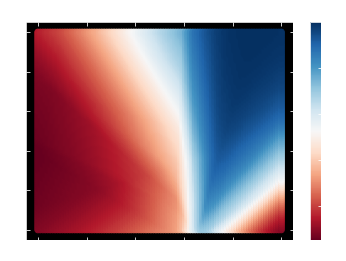

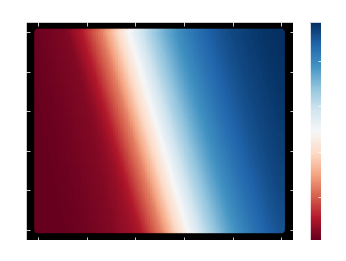

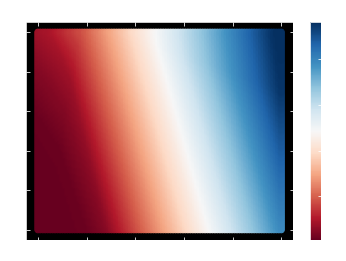

In [436]:
def plot_2dhist(model):
    X1, X2 = torch.meshgrid(torch.linspace(0,1,100), torch.linspace(0,1,100))
    X3, X4 = (torch.Tensor(X.mean(axis=0)[2:]) * torch.ones((100*100, 2))).T
    Z = model(torch.stack((X1.reshape(-1), X2.reshape(-1), X3, X4),dim=1))
    fig, ax = plt.subplots(1,1)
    sc = ax.scatter(X1.reshape(-1), X2.reshape(-1), c=Z.detach().view(-1), cmap=plt.cm.RdBu)
    plt.colorbar(sc)
    
plot_2dhist(model=model)
plt.title('unconstrained')
plot_2dhist(model=model_pnn)
plt.title('positive')
plot_2dhist(model=model_spec)
plt.title('spectral')

# 2 features - with outliers kept

naive bayes accuracy: 0.85
NN accuracy: 0.88
naive bayes auc: 0.91
NN auc: 0.92


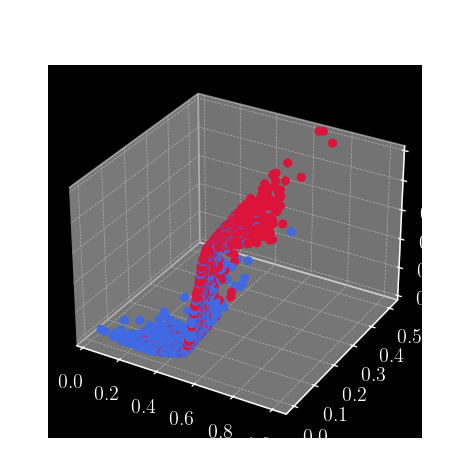

In [222]:
# unconstrained
torch.manual_seed(1)
model = PLM(get_module(inputs=5, nunits=20, nlayers=5, norm=False, activation=nn.ReLU(), batchnorm=False),lipschitz_const=1)
train(model)

naive bayes accuracy: 0.85
Spectral5 accuracy: 0.88
naive bayes auc: 0.91
Spectral5 auc: 0.92


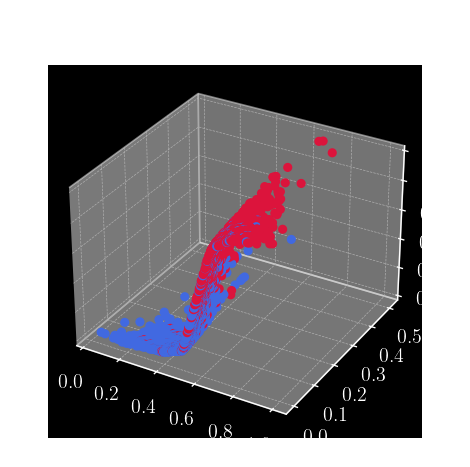

In [223]:
# lipnn5
torch.manual_seed(1)
model_spec = PLM(get_module(inputs=2, nunits=20, nlayers=6, norm=True, activation=nn.ReLU(), batchnorm=False),lipschitz_const=5)
train(model_spec, name='Spectral5')

naive bayes accuracy: 0.85
Spectral5monotonic accuracy: 0.88
naive bayes auc: 0.91
Spectral5monotonic auc: 0.92


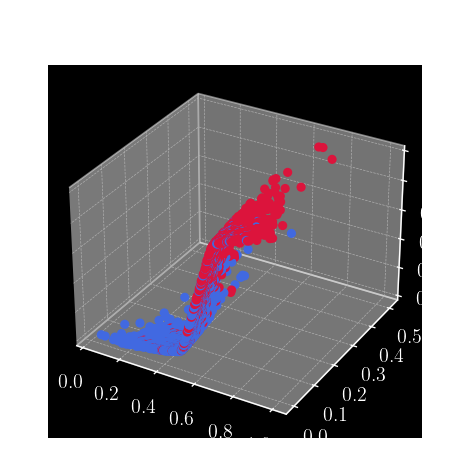

In [224]:
# Monotonic LipNN
plt.close()
torch.manual_seed(1)
module = nn.Sequential(get_module(inputs=2, nunits=32, nlayers=6, norm=spectral_norm2, activation=nn.ReLU(), 
                       layer=nn.Linear, batchnorm=False))

model_specm = PLM(module,lipschitz_const=5)
train(model_specm, name='Spectral5monotonic')

naive bayes accuracy: 0.85
PositiveNN accuracy: 0.88
naive bayes auc: 0.91
PositiveNN auc: 0.92


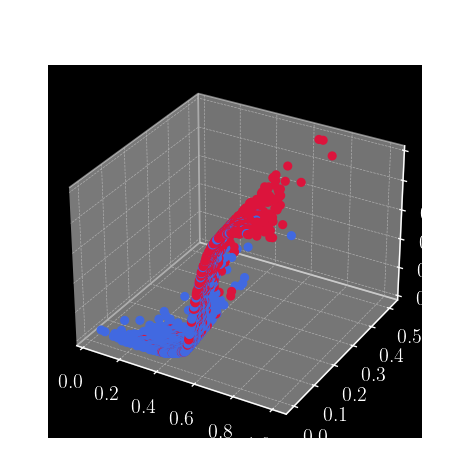

In [225]:
# positive weights
plt.close()
torch.manual_seed(1)

module = nn.Sequential(get_module(inputs=2, nunits=32, nlayers=6, norm=False, activation=nn.ReLU(), 
                       layer=PositiveLinear, batchnorm=False), torch.nn.Tanh())

model_pnn = PLM(module,lipschitz_const=1)
train(model_pnn, 'PositiveNN')

# No outliers

naive bayes accuracy: 0.86
Spectral5monotonic accuracy: 0.87
naive bayes auc: 0.89
Spectral5monotonic auc: 0.90


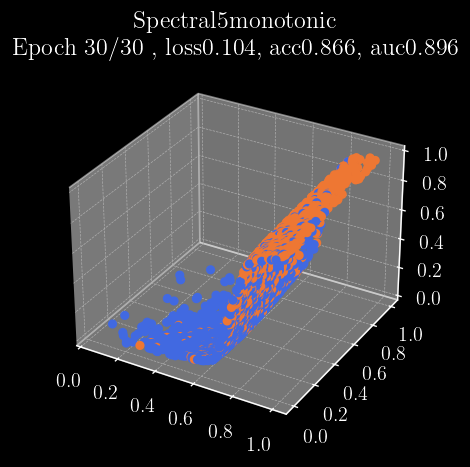

In [16]:
# Monotonic LipNN
plt.close()
torch.manual_seed(1)
module = nn.Sequential(get_module(inputs=2, nunits=32, nlayers=6, norm=spectral_norm2, activation=nn.ReLU(), 
                       layer=nn.Linear, batchnorm=False))

model_specm = PLM(module,lipschitz_const=5)
train(model_specm, name='Spectral5monotonic')

naive bayes accuracy: 0.86
Spectral5 accuracy: 0.87
naive bayes auc: 0.89
Spectral5 auc: 0.90


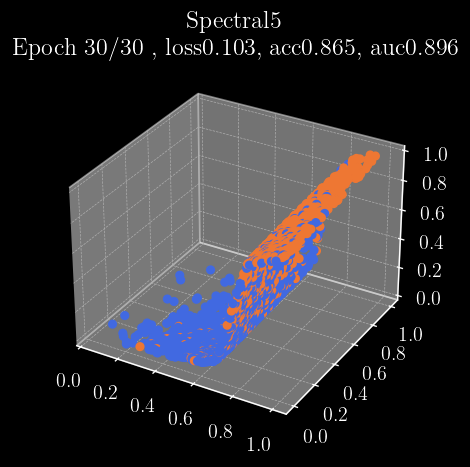

In [15]:
# lipnn5
torch.manual_seed(1)
model_spec = PLM(get_module(inputs=2, nunits=20, nlayers=6, norm=True, activation=nn.ReLU(), batchnorm=False),lipschitz_const=5)
train(model_spec, name='Spectral5')

naive bayes accuracy: 0.86
PositiveNN accuracy: 0.86
naive bayes auc: 0.89
PositiveNN auc: 0.89


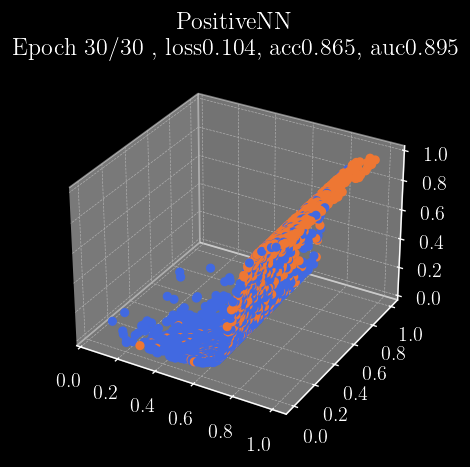

In [17]:
# positive weights
plt.close()
torch.manual_seed(1)

module = nn.Sequential(get_module(inputs=2, nunits=32, nlayers=6, norm=False, activation=nn.ReLU(), 
                       layer=PositiveLinear, batchnorm=False), torch.nn.Tanh())

model_pnn = PLM(module,lipschitz_const=1)
train(model_pnn, 'PositiveNN')

# Plotting

In [389]:
def plot_2dhist(model):
    X1, X2 = torch.meshgrid(torch.linspace(0,1,100), torch.linspace(0,1,100))
    Z = model(torch.stack((X1.reshape(-1), X2.reshape(-1)),dim=1))
    fig, ax = plt.subplots(1,1)
    sc = ax.scatter(X1.reshape(-1), X2.reshape(-1), c=Z.detach().view(-1), cmap=plt.cm.RdBu)
    plt.colorbar(sc)

Text(0.5, 1.0, 'spectral')

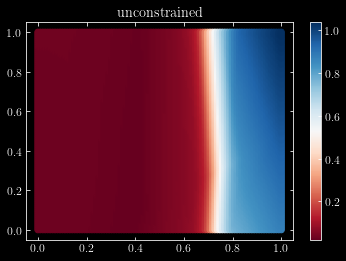

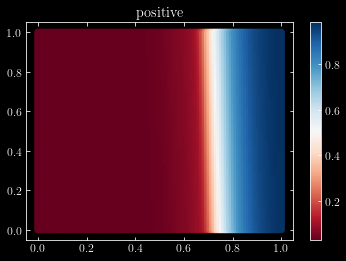

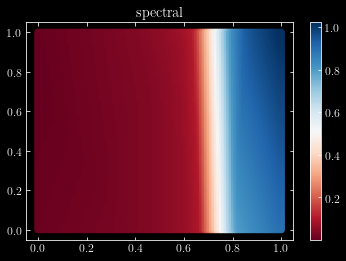

In [54]:
plot_2dhist(model=model)
plt.title('unconstrained')
plot_2dhist(model=model_pnn)
plt.title('positive')
plot_2dhist(model=model_spec)
plt.title('spectral')

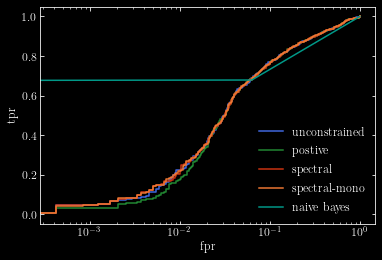

In [84]:
eps = 1e-1
for label, mod in zip(['unconstrained', 'postive', 'spectral', 'spectral-mono'],
                      [model, model_pnn, model_spec, model_specm]):
    fpr,tpr,thres = roc_curve(y_val, mod(x_val).detach())
    plt.plot(fpr,tpr, label=label)
fpr,tpr,thres = roc_curve(y_val, preds)
plt.plot(fpr,tpr, label='naive bayes')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xscale('log')
plt.legend()
plt.show()

In [392]:
5**4

625

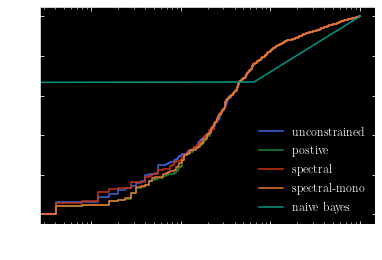

In [226]:
eps = 1e-1
for label, mod in zip(['unconstrained', 'postive', 'spectral', 'spectral-mono'],
                      [model, model_pnn, model_spec, model_specm]):
    fpr,tpr,thres = roc_curve(y_val, mod(x_val).detach())
    plt.plot(fpr,tpr, label=label)
fpr,tpr,thres = roc_curve(y_val, preds)
plt.plot(fpr,tpr, label='naive bayes')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xscale('log')
plt.legend()
plt.show()